<a href="https://colab.research.google.com/github/shahriarivari/Load-Forecasting-Machine-Learing/blob/main/load_forecasting_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### installing libraries

In [1]:
# installing jdatetime for converting date to Gregotian
# !pip install scikit-learn
# !pip install matplotlib
!pip install jdatetime
!pip install scikit-optimize
!pip install bayesian-optimization

# data manipulation

inculding: 1-becoming one with data, 2-feature engieering, and 3-preprocessing

In [2]:
import pandas as pd # to import the excel file
import numpy as np  # to deal with numbers
import jdatetime    # to convert Jalali datatime to Gregorian

In [3]:
## importing data
data_df = pd.read_excel("consumption.xlsx")
temp_df = pd.read_csv("temperature.csv")

In [4]:
# Apply the conversion directly using a lambda function
data_df['date'] = data_df['date'].apply(lambda x: jdatetime.datetime.strptime(x, '%Y/%m/%d').togregorian().strftime('%Y-%m-%d'))
data_df.rename(columns={"date": "time"}, inplace=True)

In [5]:
# making the dataframe into a column vector of time and values
# we make to lists of hours and their repective values and then concatenate them
time_hourly = []
values_hourly = []
list_of_hours = [int(col) for col in data_df.columns[1:]]
for i in range(len(data_df["time"])):
    time = pd.to_datetime(data_df['time'][i], format='%Y-%m-%d') + pd.to_timedelta(list_of_hours, unit='h').values
    values = data_df.loc[i][1:].values
    time_hourly.append(time)
    values_hourly.append(values)

In [6]:
time_concatenated = np.concatenate(time_hourly)
values_concatenated = np.concatenate(values_hourly)

In [7]:
# and now we make the new df
new_df = pd.DataFrame({"time": time_concatenated, "values": values_concatenated})
temp_df["time"] = pd.to_datetime(temp_df['time'], format='%Y-%m-%d')
print(f" changed the data frame from {data_df.shape} to {new_df.shape} ")

 changed the data frame from (730, 25) to (17520, 2) 


In [8]:
# Concatenate based on the 'Time' column
concat_df = pd.concat([new_df.set_index('time'), temp_df.set_index('time')], axis=1, join='inner')
# Reset the index to make 'Time' a column again
concat_df.reset_index(inplace=True)
concat_df.head(2)

,time,values,temp
0,2021-03-21 01:00:00,683.189471,6.7
1,2021-03-21 02:00:00,627.645948,6.1


In [9]:
# addding mutiple columns using the "time" col
concat_df["week_day"] = concat_df["time"].dt.weekday
concat_df["day"] = concat_df["time"].dt.day
concat_df['month'] = concat_df["time"].dt.month
concat_df["hour"] = concat_df["time"].dt.hour

# extracting features
concat_df['up_of_month']=(concat_df['day']<=10).astype(int)
concat_df['down_of_month']=(concat_df['day']>20).astype(int)
concat_df['sin_day']=np.sin(2*np.pi*concat_df['day']/30)
concat_df['cos_day']=np.cos(2*np.pi*concat_df['day']/30)

concat_df['morning']=((concat_df['hour']>5)&(concat_df['hour']<=12)).astype(int)
concat_df['afternoon']=((concat_df['hour']>12)&(concat_df['hour']<=19)).astype(int)
concat_df['evening']=(1-concat_df['morning']-concat_df['afternoon']).astype(int)

#  whether its thursday | friday or not
concat_df['weekend'] = ((concat_df["week_day"] == 4) | (concat_df["week_day"] == 3)).astype(int)
concat_df['time_slot'] = pd.cut(concat_df["hour"], bins=[0, 6, 12, 18, 24], labels=[1, 2, 3, 4], right=False)
concat_df['peak_load'] = ((concat_df["hour"] >= 11) & (concat_df["hour"] <= 15)).astype(int)

concat_df['spring']=((concat_df['month']>=3)&(concat_df['month']<=5)).astype(int)
concat_df['summer']=((concat_df['month']>=6)&(concat_df['month']<=8)).astype(int)
concat_df['fall']=((concat_df['month']>=9)&(concat_df['month']<=11)).astype(int)
concat_df['winter']=((concat_df['month']==12)&(concat_df['month']<=2)).astype(int)

# adding the mean of the past 4 "values" for each row
previous_four_mean = np.array(concat_df["values"][0:4].values).astype(np.float32)
for i in range(4,len(concat_df)):
  previous_four_mean = np.append(previous_four_mean, concat_df["values"][i-4:i].values.mean()).astype(np.float32)
concat_df["four_mean"] = previous_four_mean

# dropping non-informative columns
concat_df.drop( ["day", "week_day", "month","hour"] , axis = 1, inplace = True)
# concat_df.drop("time", axis=1 , inplace = True)

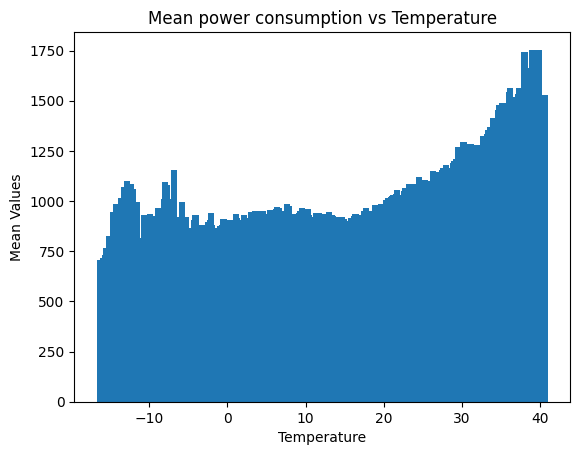

In [10]:
# plotting temperatue vs power consumption
import matplotlib.pyplot as plt

unique_temps = np.unique(concat_df['temp'])
# Plotting
plt.bar(unique_temps, concat_df.groupby('temp')['values'].mean())
plt.xlabel('Temperature')
plt.ylabel('Mean Values')
plt.title('Mean power consumption vs Temperature')
plt.show()

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(concat_df['time'], concat_df['values'], label='Time Series Data', marker='o', linestyle='-', color='b')

plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# normalizing the value and mean columns
# Normalizing using the Standard Deviation Normalization method
concat_df_value_mean = concat_df["values"].mean()
concat_df_value_std = concat_df["values"].std()
concat_df.loc[:, "values"] = (concat_df["values"] - concat_df_value_mean) / concat_df_value_std

concat_df_four_mean_mean = concat_df["four_mean"].mean()
concat_df_four_mean_std = concat_df["four_mean"].std()
concat_df.loc[:, "four_mean"] = (concat_df["four_mean"] - concat_df_four_mean_mean) / concat_df_four_mean_std

# changed the "values" columns dtype to float
concat_df["values"] = pd.to_numeric(concat_df['values'], errors='coerce').astype(float)

In [12]:
# adding 3 more features, which are the values of three previous hours
concat_df['one_hour_ago'] = concat_df['values'].shift(1)
concat_df['two_hours_ago'] = concat_df['values'].shift(2)
concat_df['three_hours_ago'] = concat_df['values'].shift(3)

columns_to_fill = ['one_hour_ago', 'two_hours_ago', 'three_hours_ago']
concat_df[columns_to_fill] = concat_df[columns_to_fill].fillna(method='bfill')

# building Model


In [13]:
from sklearn.model_selection import KFold #Import the k-fold cross validation function in the machine learning library
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [26]:
concat_df.columns

Index(['values', 'temp', 'up_of_month', 'down_of_month', 'sin_day', 'cos_day',
       'morning', 'afternoon', 'evening', 'weekend', 'time_slot', 'peak_load',
       'spring', 'summer', 'fall', 'winter', 'four_mean', 'one_hour_ago',
       'two_hours_ago', 'three_hours_ago'],
      dtype='object')

### hyper parametere tuning

In [14]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

# Assuming you have a DataFrame called concat_df with a column 'values'
# Drop any other columns that are not features or the target variable
features = concat_df.drop(columns=['values',axis =1])
target = concat_df['values']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define the objective function for Bayesian Optimization
def lgbm_cv(num_leaves, learning_rate, n_estimators, feature_fraction, bagging_fraction, bagging_freq, min_child_samples):
    params = {
        'objective': 'regression',
        'num_leaves': int(num_leaves),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'feature_fraction': max(min(feature_fraction, 1), 0),
        'bagging_fraction': max(min(bagging_fraction, 1), 0),
        'bagging_freq': int(bagging_freq),
        'min_child_samples': int(min_child_samples),
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt'
    }

    # Perform K-Fold cross-validation on the training set
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train_kf, y_train_kf)

        # Predict on the validation set and calculate RMSE
        y_pred = model.predict(X_val_kf)
        rmse = np.sqrt(mean_squared_error(y_val_kf, y_pred))
        rmse_scores.append(rmse)

    # Return the average RMSE across folds
    return -np.mean(rmse_scores)

# Define the parameter space for Bayesian Optimization
pbounds = {
    'num_leaves': (5, 50),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 200),
    'feature_fraction': (0.1, 0.9),
    'bagging_fraction': (0.1, 0.9),
    'bagging_freq': (1, 10),
    'min_child_samples': (5, 30)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=lgbm_cv,
    pbounds=pbounds,
    random_state=42,
)

# Run Bayesian Optimization
optimizer.maximize(init_points=10, n_iter=30)

# Get the best hyperparameters
best_params = optimizer.max['params']
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['bagging_freq'] = int(best_params['bagging_freq'])
best_params['min_child_samples'] = int(best_params['min_child_samples'])

|   iter    |  target   | baggin... | baggin... | featur... | learni... | min_ch... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.154    | 0.3996    | 9.556     | 0.6856    | 0.1836    | 8.9       | 73.4      | 7.614     |
| 2         | -0.1863   | 0.7929    | 6.41      | 0.6665    | 0.01597   | 29.25     | 174.9     | 14.56     |
| 3         | -0.1587   | 0.2455    | 2.651     | 0.3434    | 0.1622    | 15.8      | 93.68     | 32.53     |
| 4         | -0.1469   | 0.2116    | 3.629     | 0.3931    | 0.1423    | 24.63     | 79.95     | 28.14     |
| 5         | -0.12     | 0.5739    | 1.418     | 0.586     | 0.05945   | 6.626     | 192.3     | 48.45     |
| 6         | -0.1782   | 0.7467    | 3.742     | 0.1781    | 0.2084    | 16.0      | 68.31     | 27.28     |
| 7         | -0.1677   | 0.1275    | 9.184     | 0.307     | 0.2021    | 12.79     | 128.0     | 29.6      |
| 8       

In [15]:
best_params

{'bagging_fraction': 0.9,
 'bagging_freq': 2,
 'feature_fraction': 0.9,
 'learning_rate': 0.12442962926934377,
 'min_child_samples': 24,
 'n_estimators': 92,
 'num_leaves': 42}

In [17]:
# Train the final model with the best hyperparameters using the entire training set
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_train, y_train)

# Evaluate the final model on the test set
y_pred_test = final_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Final model RMSE on the test set: {rmse_test}")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points

In [25]:
denormalized_predict_values = (y_pred_test*concat_df_value_std) +concat_df_value_mean
denormalized_target_values = (y_test*concat_df_value_std) +concat_df_value_mean

In [26]:
denormalized_predict_values[10:20]

array([1042.56066655, 1079.227034  , 1181.0114068 ,  784.43893514,
        797.44152246,  691.58358336, 1016.86081946,  980.03643906,
       1081.21302518,  851.70726204])

In [27]:
denormalized_target_values[10:20]

9619     1085.847681
14176    1081.452896
16700    1179.721671
7207      787.178439
7231      811.285008
6627      714.855469
2281      987.646722
14230     969.468902
3669     1055.019181
6504      857.000970
Name: values, dtype: float64

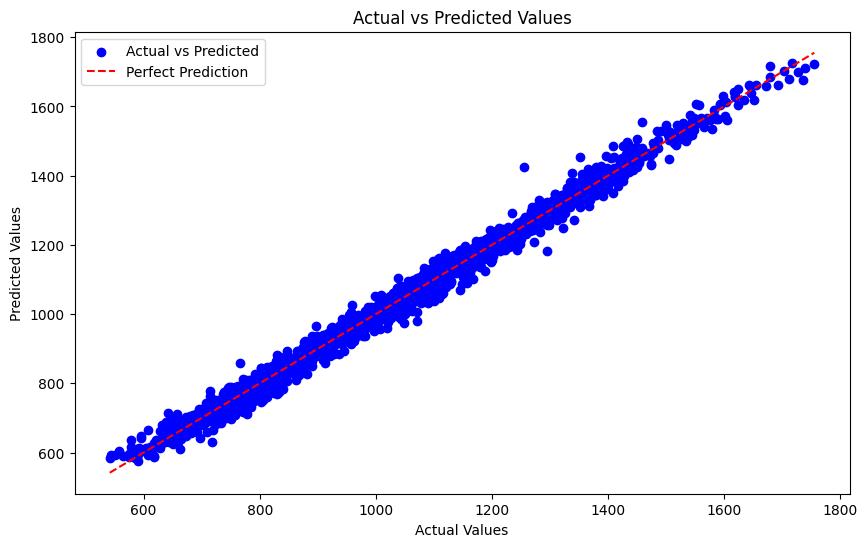

In [28]:
import matplotlib.pyplot as plt

# Plotting the actual vs predicted values on the test set
plt.figure(figsize=(10, 6))

# Plot the actual values
plt.scatter(denormalized_target_values, denormalized_predict_values, color='blue', label='Actual vs Predicted')

# Plot the line of equality (perfect prediction)
plt.plot([min(denormalized_target_values), max(denormalized_target_values)], [min(denormalized_target_values), max(denormalized_target_values)], linestyle='--', color='red', label='Perfect Prediction')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


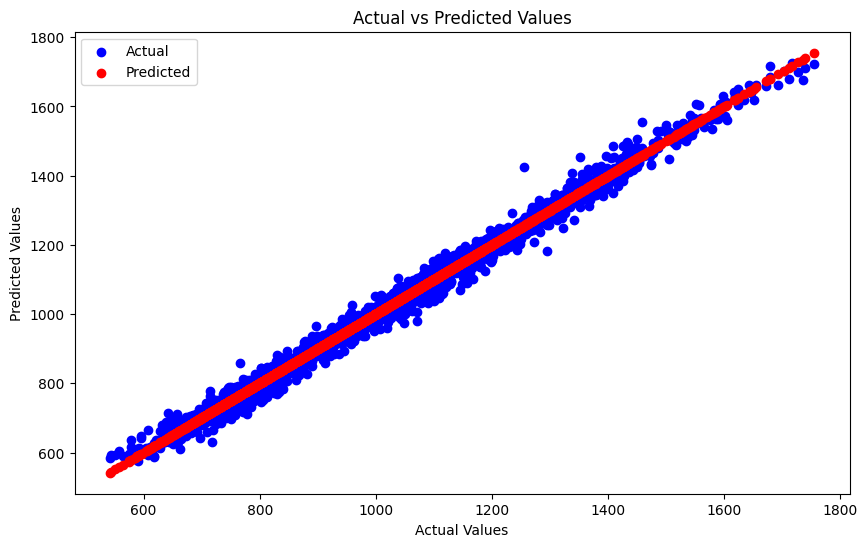

In [30]:
import matplotlib.pyplot as plt

# Plotting the actual vs predicted values on the test set
plt.figure(figsize=(10, 6))

# Plot the actual values in blue
plt.scatter(denormalized_target_values, denormalized_predict_values, color='blue', label='Actual')

# Plot the predicted values in green
plt.scatter(denormalized_target_values, denormalized_target_values, color='red', label='Predicted')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()
